# Intro
In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

I refere to https://www.kaggle.com/competitions/nlp-getting-started/discussion/533152 for the informative EDA and modeling approaches. \
The prediction is based on a BERT model (batch_size=32, epochs=5).

In [1]:
import string
import re
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras_core as keras
import keras_nlp
from transformers import BertTokenizer, BertForSequenceClassification

from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

stop = set(stopwords.words('english'))

Using TensorFlow backend


# EDA

### Data overview
- **id**: unique identifier for each tweet.
- **keyword**: particular keyword from the tweet (can be blank).
- **location**: location the tweet was sent from (can be blank).
- **text**: text of the tweet.
- **target**: the target feature, denoting if the tweet is a real disaster (1) or not (0).

In [2]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (7613, 5)
Test data shape: (3263, 4)


In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


- Let's find samples with some *keyword*.

In [7]:
# List unique values in the "keyword" column for train_data
train_keywords_list = set(train_data['keyword'].dropna().unique())

# List unique values in the "keyword" column for test_data
test_keywords_list = set(test_data['keyword'].dropna().unique())

# Combine the unique values from both train_data and test_data
combined_keywords = train_keywords_list.union(test_keywords_list)

# Display the unique keywords from both datasets
print("Unique keywords in both train_data and test_data:")
print(combined_keywords)


Unique keywords in both train_data and test_data:
{'hostages', 'hail', 'wreck', 'survive', 'obliterated', 'weapons', 'war%20zone', 'accident', 'obliteration', 'forest%20fires', 'panic', 'fatal', 'trouble', 'volcano', 'displaced', 'buildings%20burning', 'hurricane', 'mayhem', 'weapon', 'deluge', 'smoke', 'burning%20buildings', 'seismic', 'blaze', 'whirlwind', 'sinking', 'first%20responders', 'arsonist', 'wounds', 'collision', 'hellfire', 'meltdown', 'flood', 'trauma', 'cliff%20fall', 'annihilated', 'hazardous', 'injury', 'tornado', 'tsunami', 'engulfed', 'violent%20storm', 'wounded', 'rescuers', 'riot', 'flattened', 'bridge%20collapse', 'refugees', 'flooding', 'drought', 'screamed', 'fatality', 'explosion', 'dead', 'terrorist', 'arson', 'blood', 'panicking', 'danger', 'bomb', 'attacked', 'hazard', 'loud%20bang', 'quarantine', 'catastrophic', 'devastation', 'evacuation', 'inundated', 'body%20bags', 'ambulance', 'damage', 'survivors', 'evacuate', 'bloody', 'heat%20wave', 'blazing', 'suici

(Visualization about the ranking comes later.)

In [8]:
# Display rows where "keyword" column is not NaN
filtered_data = test_data[test_data['keyword'].notna()]
filtered_data.head()

,id,keyword,location,text
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...


In [10]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test_data.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

- All entries have the text value present.
- Keyword is present in most entries.
- Location is missing in many of the entries.

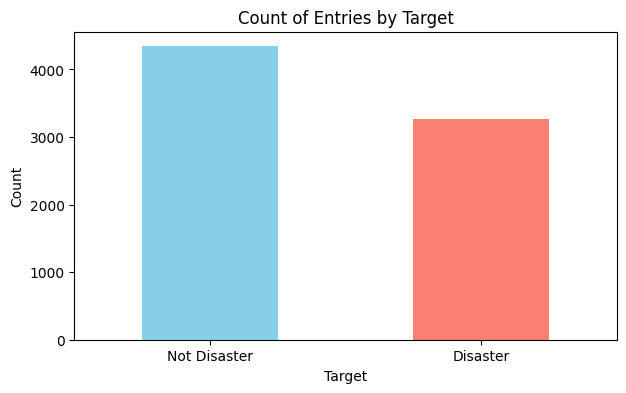

In [8]:
target_counts = train_data['target'].value_counts()

plt.figure(figsize=(7, 4))
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Entries by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)

plt.show()

- The distribution of tweets that are disaster and not disaster don't seem too unbalanced. 

In [9]:
train_data["lowercase_text"] = train_data["text"].str.lower()

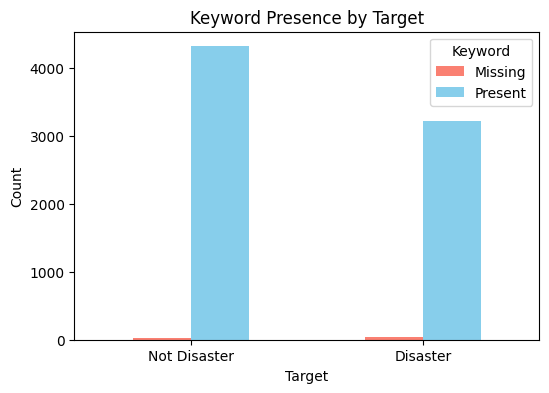

In [10]:
train_data['keyword_present'] = train_data['keyword'].apply(lambda x: 'Present' if pd.notnull(x) else 'Missing')

grouped_counts = train_data.groupby(['target', 'keyword_present']).size().unstack()

grouped_counts.plot(kind='bar', figsize=(6, 4), color=['salmon', 'skyblue'])
plt.title('Keyword Presence by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)
plt.legend(title='Keyword', loc='upper right')

plt.show()

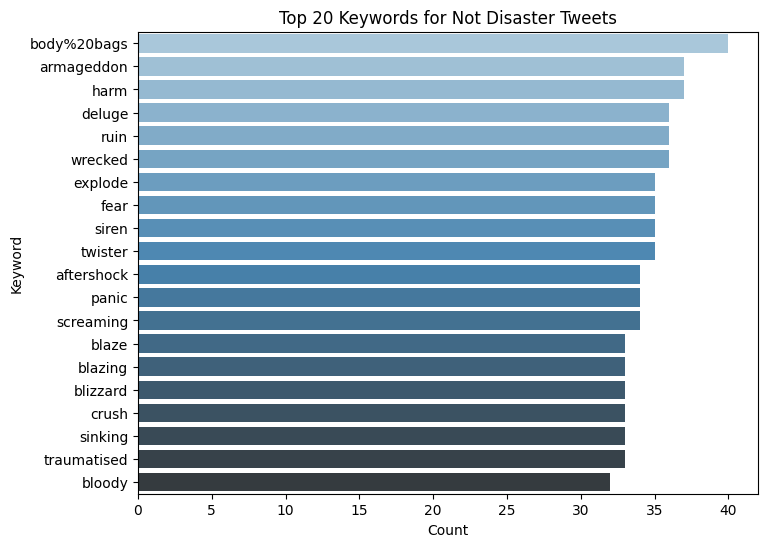

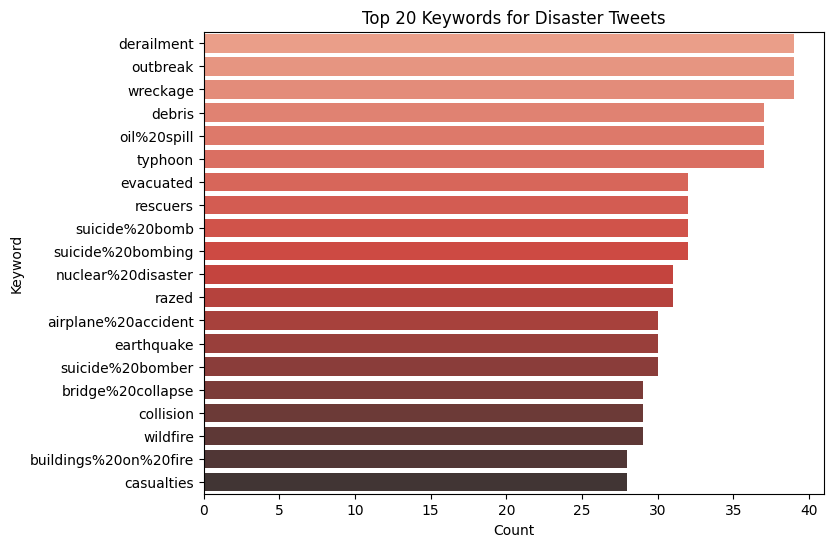

In [11]:
df_filtered = train_data[train_data['keyword'].notnull()]

keywords_target_0 = df_filtered[df_filtered['target'] == 0]['keyword']
keywords_target_1 = df_filtered[df_filtered['target'] == 1]['keyword']

top_20_keywords_0 = Counter(keywords_target_0).most_common(20)
top_20_keywords_1 = Counter(keywords_target_1).most_common(20)

df_top_20_0 = pd.DataFrame(top_20_keywords_0, columns=['Keyword', 'Count'])
df_top_20_1 = pd.DataFrame(top_20_keywords_1, columns=['Keyword', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Keyword', data=df_top_20_0, palette="Blues_d")
plt.title('Top 20 Keywords for Not Disaster Tweets')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Keyword', data=df_top_20_1, palette="Reds_d")
plt.title('Top 20 Keywords for Disaster Tweets')
plt.show()

- The top common keywords are fairly different between the disaster and non-disaster tweets.

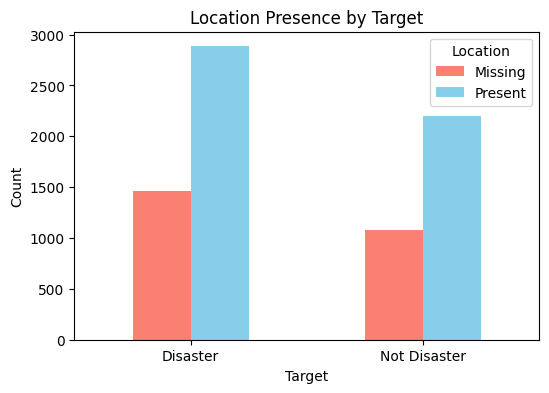

In [12]:
train_data['location_present'] = train_data['location'].apply(lambda x: 'Present' if pd.notnull(x) else 'Missing')

grouped_counts = train_data.groupby(['target', 'location_present']).size().unstack()

grouped_counts.plot(kind='bar', figsize=(6, 4), color=['salmon', 'skyblue'])
plt.title('Location Presence by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Disaster', 'Not Disaster'], rotation=0)
plt.legend(title='Location', loc='upper right')

plt.show()

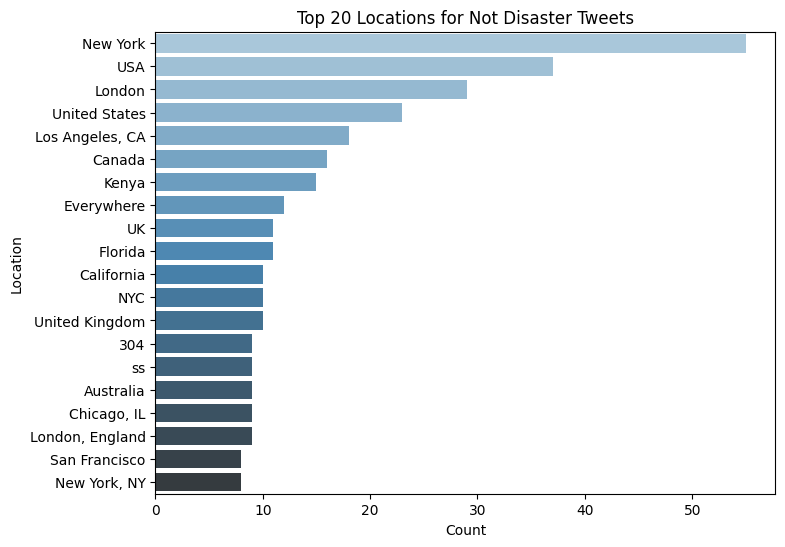

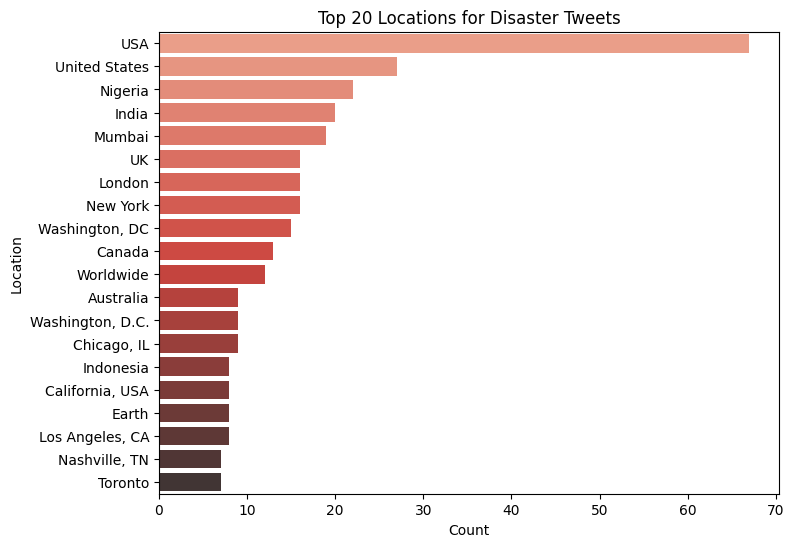

In [13]:
df_filtered = train_data[train_data['location'].notnull()]

locations_target_0 = df_filtered[df_filtered['target'] == 0]['location']
locations_target_1 = df_filtered[df_filtered['target'] == 1]['location']

top_20_locations_0 = Counter(locations_target_0).most_common(20)
top_20_locations_1 = Counter(locations_target_1).most_common(20)

df_top_20_0 = pd.DataFrame(top_20_locations_0, columns=['Location', 'Count'])
df_top_20_1 = pd.DataFrame(top_20_locations_1, columns=['Location', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Location', data=df_top_20_0, palette="Blues_d")
plt.title('Top 20 Locations for Not Disaster Tweets')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Location', data=df_top_20_1, palette="Reds_d")
plt.title('Top 20 Locations for Disaster Tweets')
plt.show()

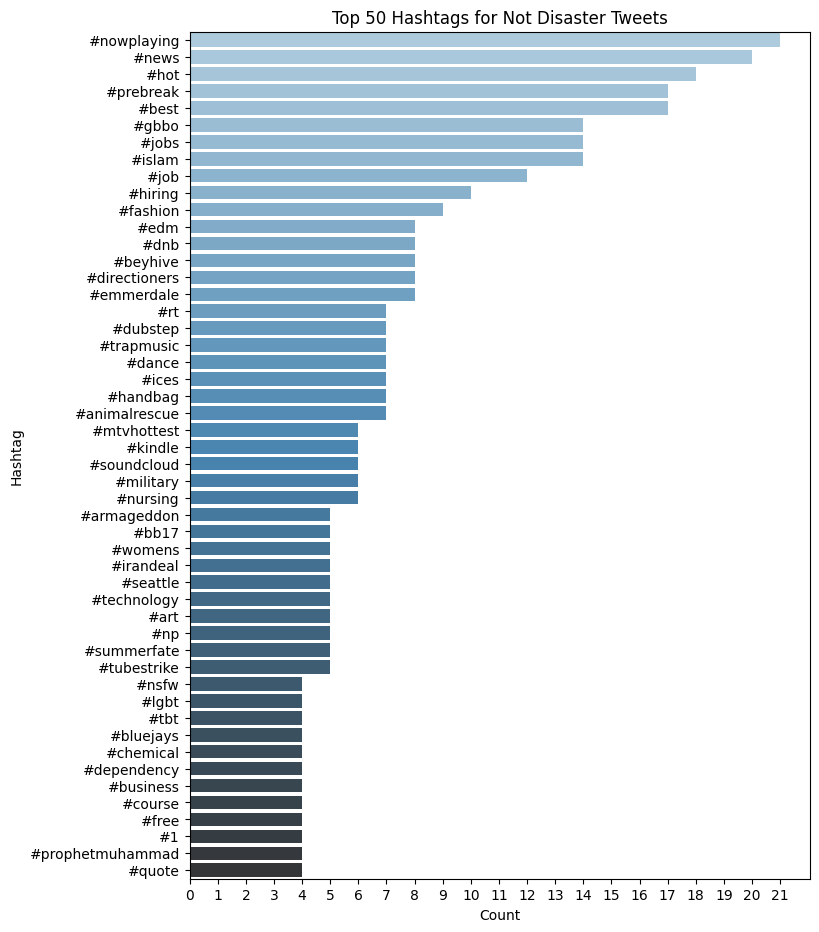

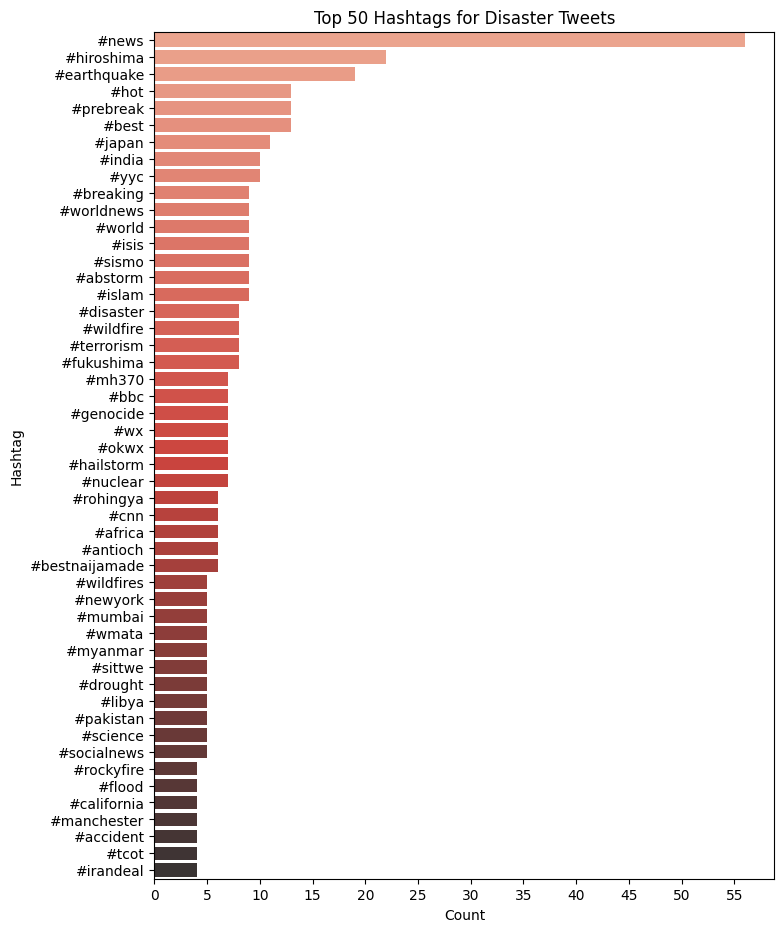

In [14]:
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

train_data['hashtags'] = train_data['lowercase_text'].apply(extract_hashtags)
hashtags_target_0 = [hashtag for hashtags, target in zip(train_data['hashtags'], train_data['target']) if target == 0 for hashtag in hashtags]
hashtags_target_1 = [hashtag for hashtags, target in zip(train_data['hashtags'], train_data['target']) if target == 1 for hashtag in hashtags]

top_50_hashtags_0 = Counter(hashtags_target_0).most_common(50)
top_50_hashtags_1 = Counter(hashtags_target_1).most_common(50)

df_top_50_0 = pd.DataFrame(top_50_hashtags_0, columns=['Hashtag', 'Count'])
df_top_50_1 = pd.DataFrame(top_50_hashtags_1, columns=['Hashtag', 'Count'])

plt.figure(figsize=(8, 11))
sns.barplot(x='Count', y='Hashtag', data=df_top_50_0, palette="Blues_d")
plt.xticks(np.arange(0, df_top_50_0['Count'].max() + 1, step=1))
plt.title('Top 50 Hashtags for Not Disaster Tweets')
plt.show()

plt.figure(figsize=(8, 11))
sns.barplot(x='Count', y='Hashtag', data=df_top_50_1, palette="Reds_d")
plt.xticks(np.arange(0, df_top_50_1['Count'].max() + 1, step=5))
plt.title('Top 50 Hashtags for Disaster Tweets')
plt.show()

- The distributions for the word count, character count, average word length, and stopword counts in both disaster and non-disaster tweets seem to be pretty similar.

# Data Preprocessing

The process below checks if there are entries with the same text but differing target values, as this can harm the training.

In [20]:
duplicate_text = train_data[train_data["text"].duplicated(keep=False)]
unique_targets = duplicate_text.groupby('text').filter(lambda x: x["target"].nunique() != 1)
indices = unique_targets.index.tolist()

In the following example, the text is the same for both entries, but the target values are different.

In [21]:
for index in indices[:2]:
    print(train_data.loc[index])

id                                            881
keyword                              bioterrorism
location                                      NaN
text                   To fight bioterrorism sir.
target                                          1
lowercase_text         to fight bioterrorism sir.
keyword_present                           Present
location_present                          Missing
hashtags                                       []
word_count                                      4
char_count                                     26
average_word_length                          5.75
stopword_count                                  1
Name: 610, dtype: object
id                                            898
keyword                              bioterrorism
location                                      NaN
text                   To fight bioterrorism sir.
target                                          0
lowercase_text         to fight bioterrorism sir.
keyword_present          

I manually go through and fix the duplicate entries with the mismatching targets.

In [22]:
# Fix targets for duplicated tweets
train_data.loc[610, 'target'] = 0
train_data.loc[630, 'target'] = 0
train_data.loc[1197, 'target'] = 0
train_data.loc[1221, 'target'] = 0
train_data.loc[1365, 'target'] = 0

train_data.loc[2830, 'target'] = 0
train_data.loc[2831, 'target'] = 0
train_data.loc[2833, 'target'] = 0

train_data.loc[3243, 'target'] = 0
train_data.loc[3248, 'target'] = 0
train_data.loc[3985, 'target'] = 0
train_data.loc[4221, 'target'] = 0
train_data.loc[4232, 'target'] = 0
train_data.loc[4239, 'target'] = 0
train_data.loc[4292, 'target'] = 0
train_data.loc[4305, 'target'] = 0
train_data.loc[4312, 'target'] = 0
train_data.loc[4318, 'target'] = 0
train_data.loc[4320, 'target'] = 0

train_data.loc[4381, 'target'] = 0
train_data.loc[4618, 'target'] = 1
train_data.loc[5620, 'target'] = 0
train_data.loc[6091, 'target'] = 0
train_data.loc[6123, 'target'] = 0
train_data.loc[6616, 'target'] = 0

## Cleaning text data

The following techniques are applied to clean up the text:
- Make text lowercase
- Remove url's
- Remove HTML tags
- Remove punctuation
- Remove numbers
- Remove empty spaces
- Remove stopwords

In [23]:
def clean_text(text):
    text = text.lower()
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_empty_spaces(text)
    text = remove_stopwords(text)
    return text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuation(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

def remove_empty_spaces(text):
    words = [word for word in text.split(" ") if (not word.strip() == "")]
    return " ".join(words)

def remove_stopwords(text):
    words = [word for word in text.split(" ") if word not in stop]
    return " ".join(words)


In [25]:
example = train_data["text"].iloc[0]
print("Before cleaning:", example)
print("After cleaning: ", clean_text(example))

Before cleaning: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After cleaning:  deeds reason earthquake may allah forgive us


In [26]:
train_data["cleaned_text"] = train_data["text"].apply(clean_text)
test_data["cleaned_text"] = test_data["text"].apply(clean_text)

# Modeling (BERT model)

In [28]:
BATCH_SIZE = 32
EPOCHS = 5

In [29]:
X = train_data["cleaned_text"]
y = train_data["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_data["cleaned_text"]

In [30]:
preset = "bert_base_en_uncased"

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset=preset,
    sequence_length=160
)

classifier = keras_nlp.models.BertClassifier.from_preset(
    preset=preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0
)

In [33]:
classifier.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/5


I0000 00:00:1727427897.700270     119 service.cc:145] XLA service 0x79cb880139c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727427897.700341     119 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727427897.700347     119 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727427944.758763     149 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38140', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1727427951.104223     149 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_76', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1727427995.821538     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_97', 120 bytes spill stores, 120 bytes spill loads
ptxa

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7205 - loss: 0.5603

I0000 00:00:1727428192.044234     185 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_469', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1727428194.753995     184 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_493', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1727428199.510788     182 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_469', 1256 bytes spill stores, 1212 bytes spill loads

I0000 00:00:1727428246.693840     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 120 bytes spill stores, 120 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 64 bytes spill stores, 64 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.7211 - loss: 0.5596 - val_accuracy: 0.8293 - val_loss: 0.4117
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 172s 902ms/step - accuracy: 0.8409 - loss: 0.3791 - val_accuracy: 0.8286 - val_loss: 0.4027
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 170s 889ms/step - accuracy: 0.8765 - loss: 0.3143 - val_accuracy: 0.8273 - val_loss: 0.4173
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 892ms/step - accuracy: 0.9090 - loss: 0.2560 - val_accuracy: 0.8201 - val_loss: 0.4703


In [34]:
y_train_pred = classifier.predict(X_train)

191/191 ━━━━━━━━━━━━━━━━━━━━ 65s 323ms/step


F1 score: 0.8729575163398693


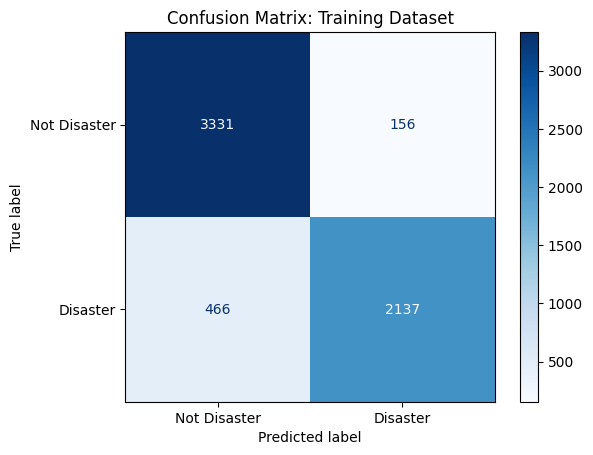

In [35]:
display = ConfusionMatrixDisplay.from_predictions(
    y_train,
    np.argmax(y_train_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap=plt.cm.Blues
)
display.ax_.set_title("Confusion Matrix: Training Dataset")

tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_train_pred, axis=1)).ravel()
f1_score = tp / (tp + (fp + fn) / 2)

print("F1 score:", f1_score)

In [36]:
y_val_pred = classifier.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step


F1 score: 0.7865903515944399


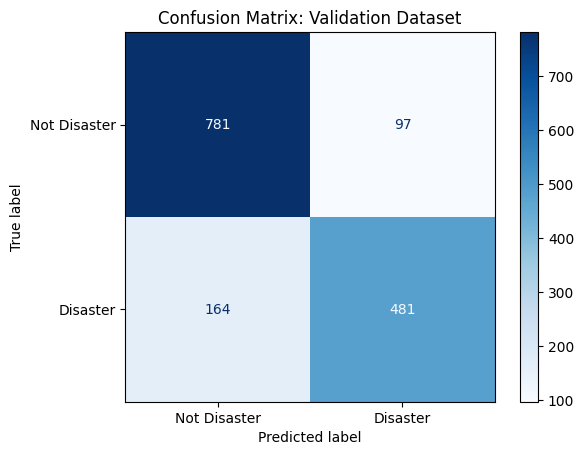

In [37]:
display = ConfusionMatrixDisplay.from_predictions(
    y_val,
    np.argmax(y_val_pred, axis=1),
    display_labels=["Not Disaster", "Disaster"],
    cmap=plt.cm.Blues
)
display.ax_.set_title("Confusion Matrix: Validation Dataset")

tn, fp, fn, tp = confusion_matrix(y_val, np.argmax(y_val_pred, axis=1)).ravel()
f1_score = tp / (tp + (fp + fn) / 2)

print("F1 score:", f1_score)

## Submission

In [38]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

sample_submission.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 336ms/step
Your submission was successfully saved!
